# Dislocation identification from orthogonal reconstructions

This notebook demonstrates a workflow to identify dislocations using orthogonal reconstructions.
Only the reconstructed **density** and **phase** are required as inputs.

Overview:
- Load orthogonal reconstruction
- Extract amplitude (density) and phase
- Compute dislocation signature from phase discontinuities and density features
- Visualise candidate dislocation locations

Notes: Keep the input reconstructions aligned and sampled consistently across axes.

## Load dataset

In [1]:
import numpy as np
from matplotlib import rcParams

import cdiutils
from cdiutils.analysis import dislo
from cdiutils.utils import fill_up_support, nan_to_zero, zero_to_nan

# Plotting configurations
rcParams.update(
    {
        #     #"font.family": "Liberation Serif",  # Use for titles, labels, and body text
        #     # "font.size": 14,         # General font size
        #     # "axes.labelsize": 14,    # X and Y labels font size
        #     # "xtick.labelsize": 14,   # X-axis tick labels
        #     # "ytick.labelsize": 14,   # Y-axis tick labels
        #     # "legend.fontsize": 14,   # Legend font size
        #     # "axes.titlesize": 14,    # Title font size
        "savefig.bbox": "tight",
        #     'axes.linewidth': 2.0,   # axis box (spines)
        #     'grid.linewidth': 2.0,
        #     'grid.linestyle': 'dotted',
        "grid.alpha": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.major.size": 0.5,
        "ytick.major.size": 0.5,
        "font.weight": "bold",
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "figure.dpi": 150,
    }
)

In [2]:
# path_to_data = "path/to/your/dataset.npy"
path_to_data = "C:\\Users\\aboud\\data\\S457_amp-phase_bulk.npz"
data = np.load(path_to_data)
density = data["amp"]
phase = -data[
    "phase"
]  # the minus since this is the raw phase of pynx reconstruction
voxel_size = [float(i) for i in data["voxel_size"]]  # in nm

new_mask = nan_to_zero(density) / np.nanmax(density) > 0.05
new_mask = fill_up_support(fill_up_support(new_mask))
density *= new_mask
phase *= new_mask
obj = density * np.exp(1j * phase)

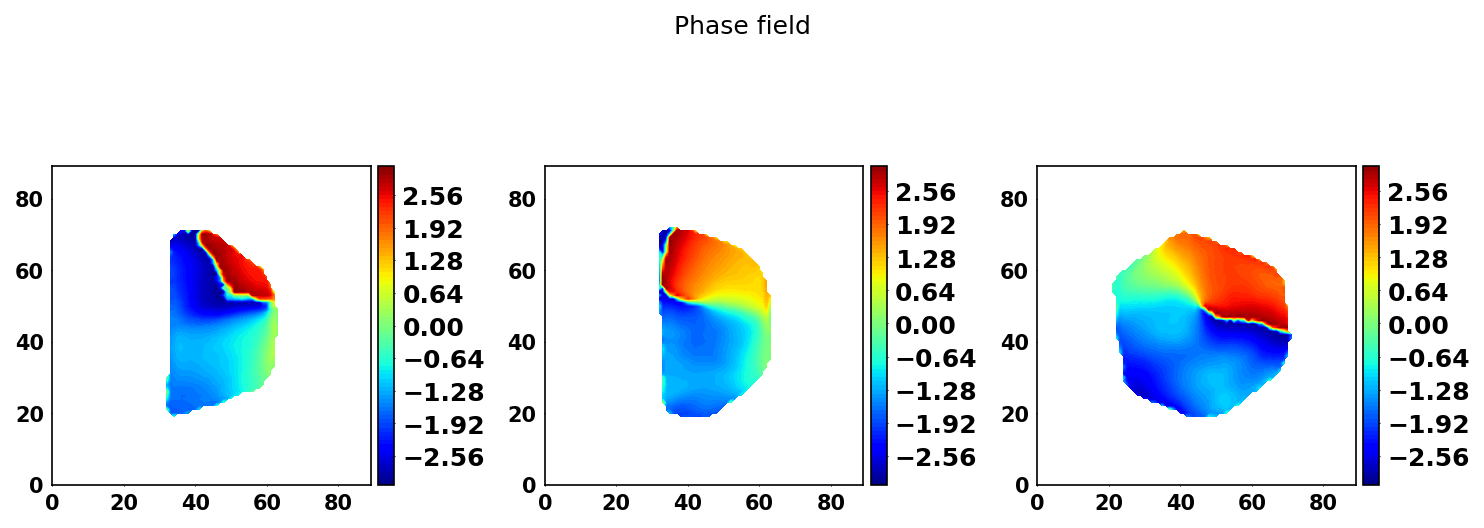

In [3]:
figure, axes = cdiutils.plot.plot_volume_slices(
    zero_to_nan(phase),
    plot_type="contourf",
    title="Phase field",
    figsize=(10, 4),
    label_size=12,
    cmap="jet",
    vmin=-np.pi,
    vmax=np.pi,
)
# figure.savefig("original_phase.png")

In [4]:
from cdiutils.interactive import Plotter

Plotter((density), plot="3D")

Error updating plot: No surface found at the given iso value.
Error updating plot: No surface found at the given iso value.


ThreeDViewer(children=(FigureWidget({
    'data': [],
    'layout': {'dragmode': 'orbit',
               'heig…

## compute the minimum gradient of the phase field


In [5]:
support_strain, strain_min = dislo.map_min_gradient(
    obj=obj,
    voxel_size=voxel_size,
    save_filename_vti="dislo_fig/ortho_gradient_map.vti",
    plot_debug=False,
    path_to_save="",
    save_plot=False,
)

# apply a threshoold
stain_threshold = 0.35
strain_min[strain_min < 0.3] = 0

"amp"/"density" not in fieldnames, will save arrays without thresholding


## Analysis
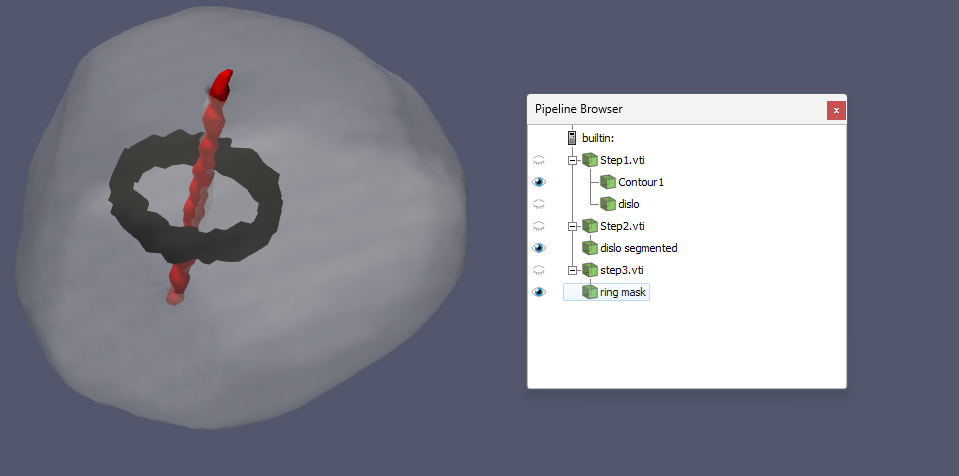

## cleaning
here you can cut the segmented phase jump as there are noise espacilly near the surface and the orthogonalisation procesure.

The best is to compute this parametre before orthogonalisation then orthogonolise it. It is much better and cleaner

In [6]:
# use this plot and the vti to see if the clustering later works or no and adjust the parameters.

# figure, axes=cdiutils.plot.plot_volume_slices(
#     zero_to_nan(phase)[:,:,40:],plot_type='contourf',
#     title="Phase field", figsize=(10,4),label_size=12,
#     cmap='jet',
#     vmin=-np.pi, vmax=np.pi
#     );

In [7]:
# if the strain_min is computed before the orthogonalisation then orthogonalised itself, much better and cleaner (which is my case)
strain_min = data["strain_amp"]

In [8]:
# strain_min[:35]=0
# strain_min[:,:35]=0
# strain_min[:,:,:40]=0
# strain_min[60:]=0
# strain_min[:,55:]=0
# strain_min[:,:,55:]=0

In [9]:
from cdiutils.interactive.multiviewer_3d import MultiVolumeViewer

In [31]:
dict_data = {
    "density": density,
    "phase": phase,
    "dislo": strain_min,
}
viewer = MultiVolumeViewer(
    dict_data,
    figsize=(9, 6),
)
viewer.show()

MultiVolumeViewer(children=(FigureWidget({
    'data': [{'cmax': 0.7347366772220124,
              'cmin': 0.7…

### clusering the voxels that have a phase jump

In [11]:
final_labeled_clusters, num_final_clusters = dislo.clusters_dislo_strain_map(
    data=strain_min,
    amp=density,
    phase=phase,
    save_path="step1",
    voxel_sizes=tuple(voxel_size),
    threshold=stain_threshold,
    min_cluster_size=2,
    distance_threshold=2.0,
    cylinder_radius=1,
    num_spline_points=5000,
    smoothing_param=4,
    eps=2.5,
    min_samples=10,
    save_output=True,
    debug_plot=False,
)

dislo.save_to_vti(
    filename="dislo_fig/Step1.vti",
    voxel_size=tuple(voxel_size),
    tuple_array=(
        nan_to_zero(density),
        nan_to_zero(phase),
        final_labeled_clusters,
        strain_min,
    ),
    tuple_fieldnames=("density", "phase", "dislo", "strain"),
    amplitude_threshold=0.01,
)

Number of clusters identified: 3
Filtered clusters: [3]
Cylindrical mask constructed.


### unify the clusters related to dislocation line and create a cylinder based on the cluster

In [12]:
threshold_dislo_cluster = 0.5
unique_labels = np.unique(final_labeled_clusters)
print(unique_labels)
points = dislo.extract_structure(
    final_labeled_clusters, threshold_dislo_cluster
)
# Fit a line to the extracted points
centroid, direction = dislo.fit_line_3d(points)
# Generate a filled cylinder in the same shape as the original volume
filled_cylinder_volume = dislo.generate_filled_cylinder(
    shape=final_labeled_clusters.shape,
    centroid=centroid,
    direction=direction,
    radius=1,
    height=100,
    step=1,
)
selected_dislocation_data = filled_cylinder_volume * new_mask


dislo.save_to_vti(
    filename="dislo_fig/Step2.vti",
    voxel_size=tuple(voxel_size),
    tuple_array=(
        nan_to_zero(density),
        nan_to_zero(phase),
        selected_dislocation_data,
        strain_min,
    ),
    tuple_fieldnames=("density", "phase", "dislo", "strain"),
    amplitude_threshold=0.01,
)

[0 1]


In [13]:
all_data_raw_and_ortho_dict = {
    "density": density,
    "phase": phase,
    "obj": obj,
    "strain_min": strain_min,
    "dislo": selected_dislocation_data,
}
# np.savez_compressed("step1_2_dislo",**all_data_raw_and_ortho_dict)

In [32]:
viewer = MultiVolumeViewer(
    all_data_raw_and_ortho_dict,
    figsize=(9, 6),
)
viewer.show()

MultiVolumeViewer(children=(FigureWidget({
    'data': [{'cmax': 0.7347366772220124,
              'cmin': 0.7…

## plot phase around dislocation

In [15]:
radius_1 = 7  # 1 -> 15 nm
dz = 2
dr = 2
selected_point_index = 0
threshold_dislo_cluster = 0.5

points = dislo.extract_structure(
    selected_dislocation_data, threshold_dislo_cluster
)
centroid, exp_direction = dislo.fit_line_3d(points)
# the direction is the direction of the dislocation line in the current frame after segmentation

In [16]:
# the displacement_vectors contain the vector of the voxel in the ring choosed and the centre of the dislocation in the current ref frame
(
    phase_ring_3d,
    angle_ring_3d,
    circular_mask,
    displacement_vectors,
    direction,
) = dislo.plot_phase_around_dislo(
    density,
    phase,
    selected_dislocation_data,
    radius_1,
    dr,
    centroid,
    exp_direction,
    slice_thickness=dz,
    voxel_sizes=voxel_size,
    selected_point_index=selected_point_index,
    save_vti=True,
    fig_title=None,
    save_path="dislo_fig/step3",
)

 checking the results directly in notebook using MultiVolumeViewer
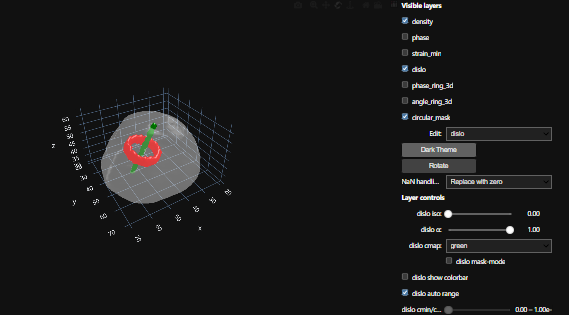

In [33]:
viewer = MultiVolumeViewer(
    {
        "density": density,
        "phase": phase,
        "strain_min": strain_min,
        "dislo": selected_dislocation_data,
        "phase_ring_3d": phase_ring_3d,
        "angle_ring_3d": angle_ring_3d,
        "circular_mask": circular_mask,
    },
    figsize=(9, 6),
)
viewer.show()

MultiVolumeViewer(children=(FigureWidget({
    'data': [{'cmax': 0.7347366772220124,
              'cmin': 0.7…

In [18]:
phase_ring_3d = nan_to_zero(phase_ring_3d)

In [19]:
results___ = dislo.dislo_process_phase_ring(
    angle_ring_3d,
    phase_ring_3d,
    displacement_vectors,
    factor_phase=+1.0,
    plot_debug=True,
    save_path="dislo_fig/step4.pdf",
)

Raw angle : -179.24362 179.38669
Raw phase : -172.47305665095348 173.66661009827837
unwrapped phase : -190.2186981806769 311.09983401841436


### CLean data in the jump part

In [20]:
conditions = (  # ( (phase_ring_3d-angle_ring_3d < 2.6) & (phase_ring_3d-angle_ring_3d >= -3.4) ) &
    (angle_ring_3d < 0.52) & (angle_ring_3d > 0.3)
)
phase_ring_3d_clean = np.array(phase_ring_3d)
angle_ring_3d_clean = np.array(angle_ring_3d)
phase_ring_3d_clean[conditions] = 0
angle_ring_3d_clean[conditions] = 0

Raw angle : -179.24362 179.38669
Raw phase : -170.63139793033577 173.33815041665468
unwrapped phase : -51.11729422932207 311.09983401841436


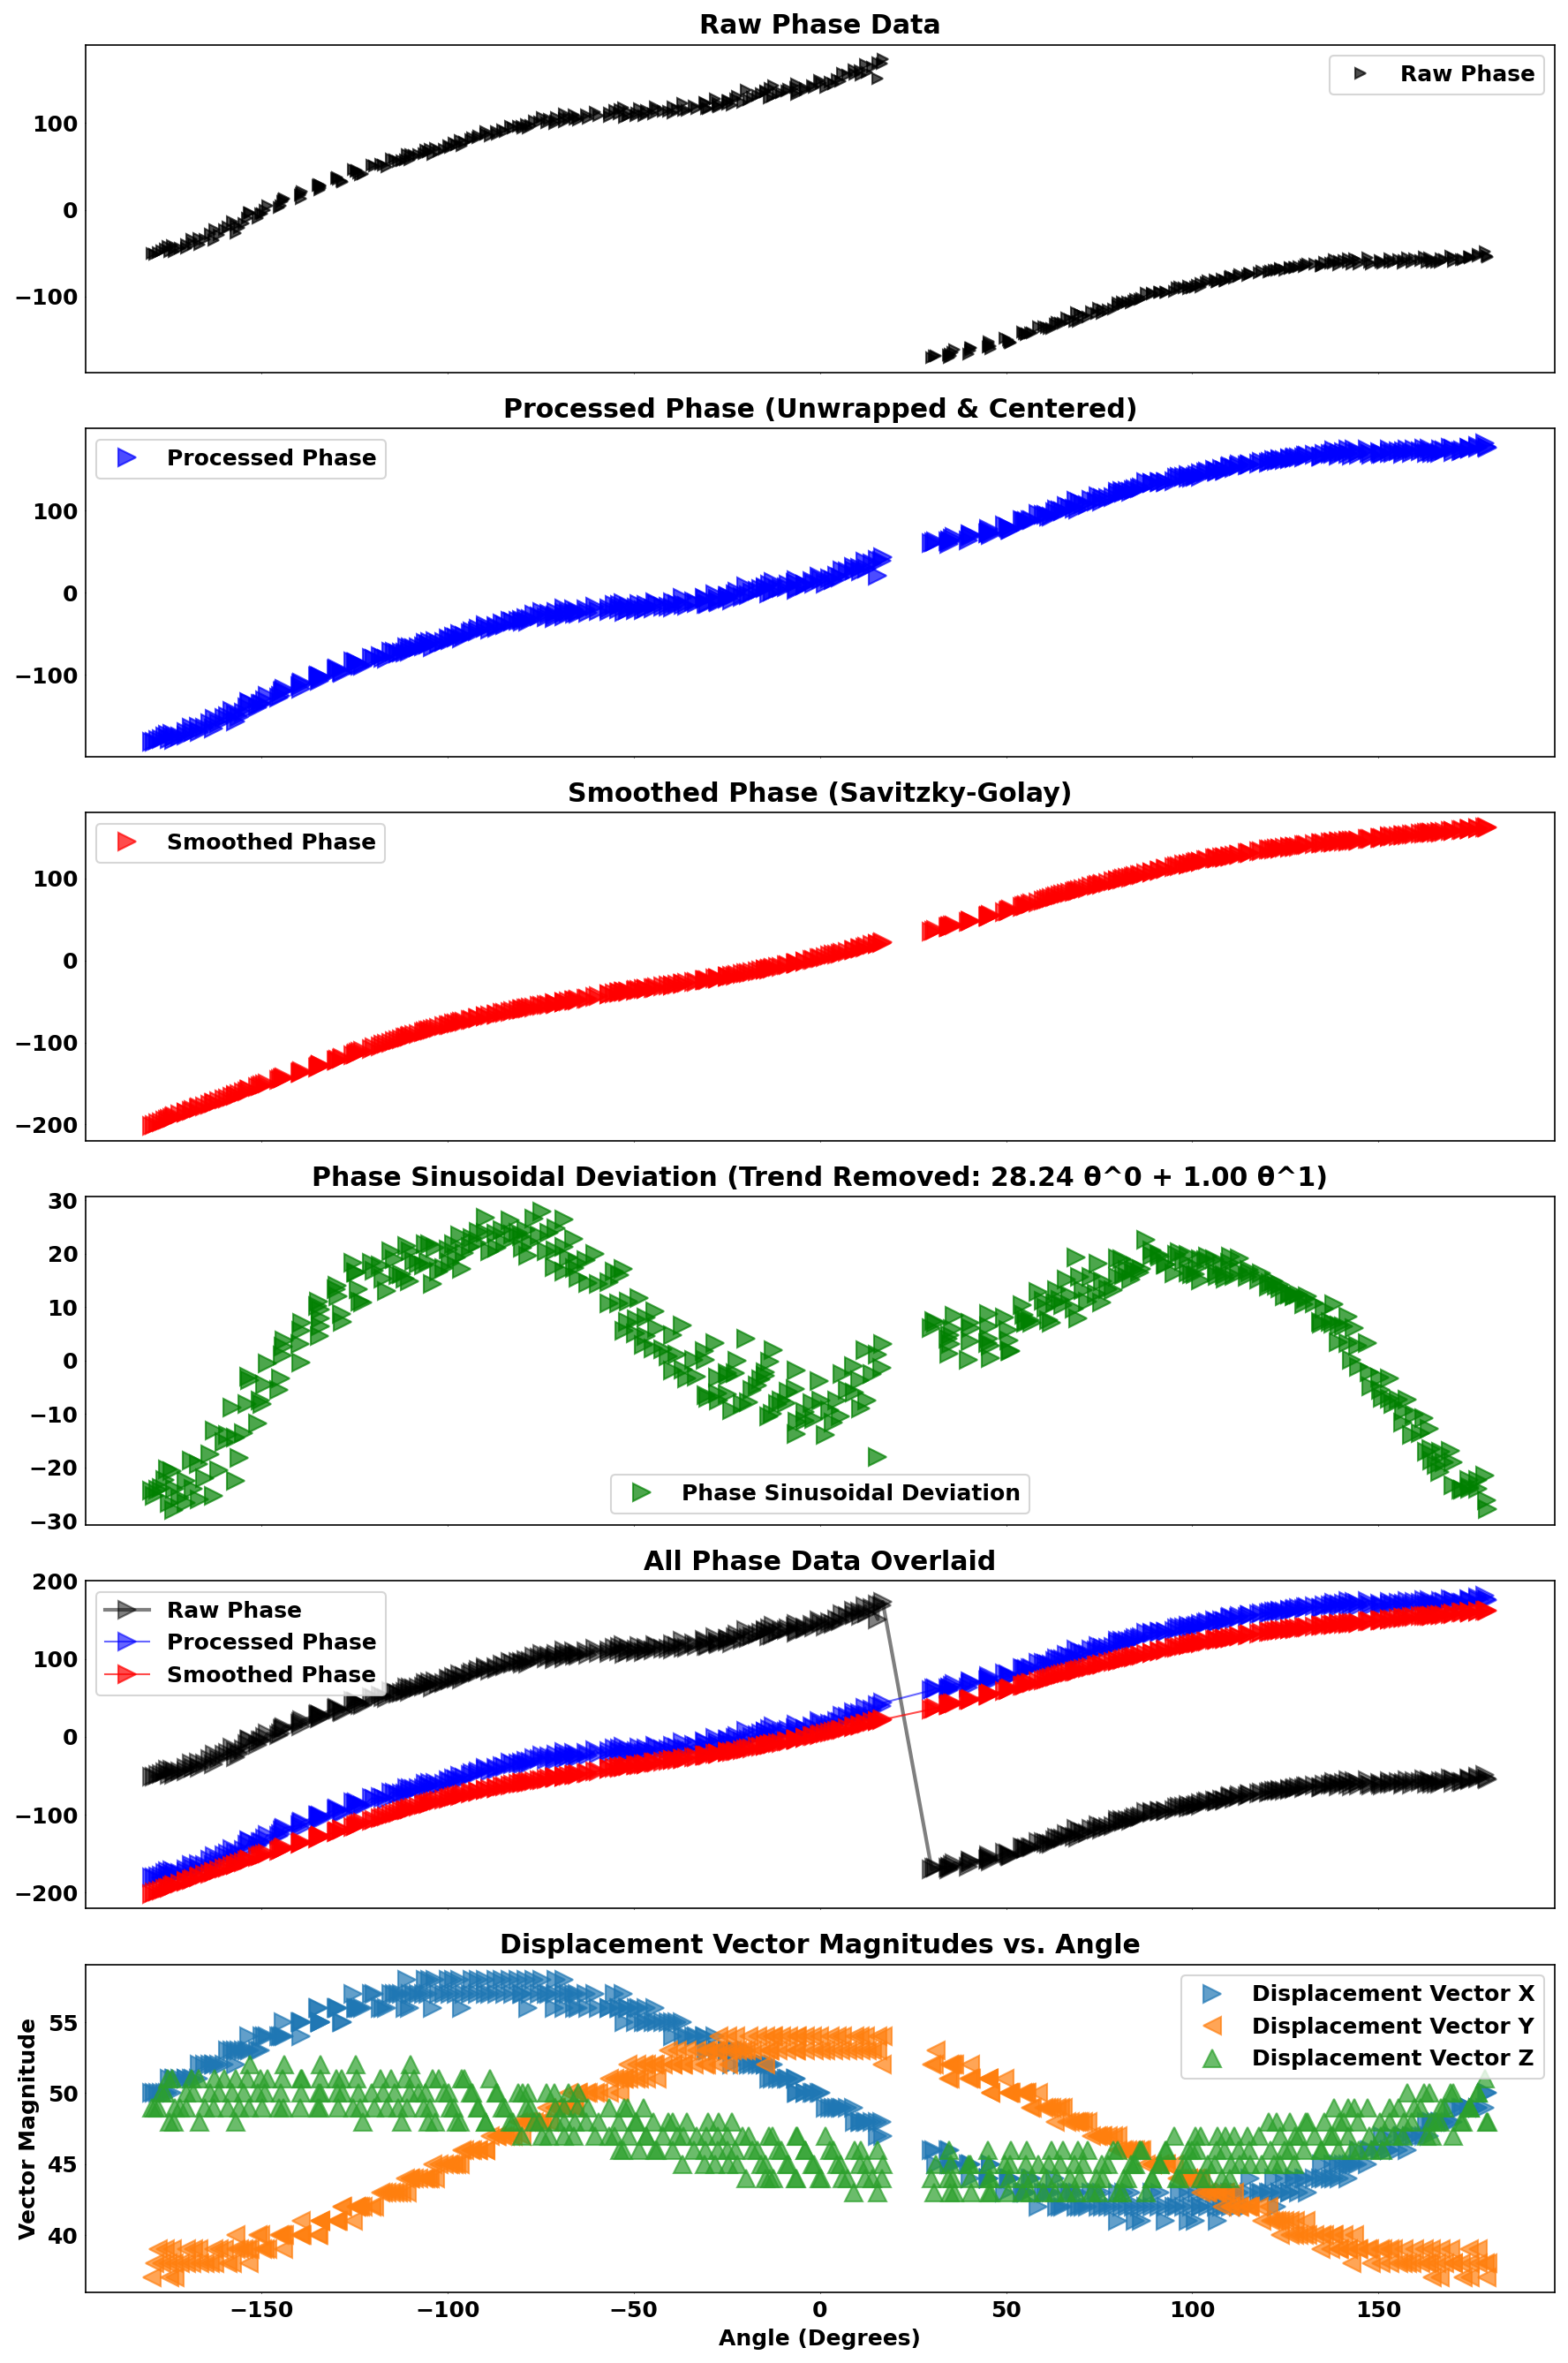

In [21]:
# (angle_raw, phase_raw, angle_final, phase_final, phase_smooth,phase_sinu, displacement_vectors_ring_sorted, displacement_vectors_final)
(_, _, angle_final, phase_final, _, _, _, displacement_vectors_final) = (
    dislo.dislo_process_phase_ring(
        angle_ring_3d_clean,
        phase_ring_3d_clean,
        displacement_vectors,
        factor_phase=-1.0,
        plot_debug=True,
        save_path="dislo_fig/step4beta.pdf",
    )
)

## Identification of burger vector from theoritical model

### General parametre definition 

In [22]:
# must be known for the current orthogonalised frame
Rotation_matix_cristallographic_to_crystal_final = np.array(
    [
        [-0.75403343, 0.64962679, 0.09704953],
        [-0.3200682, -0.49242258, 0.80936787],
        [0.57357644, 0.57922797, 0.57922797],
    ]
)
Rotation_matix_crystal_to_cristallographic_final = np.linalg.inv(
    Rotation_matix_cristallographic_to_crystal_final
)

In [23]:
# the displacement_vectors contain the vector of the voxel in the ring choosed and the centre of the dislocation in the current ref frame
vx_example = displacement_vectors_final[..., 0]
vy_example = displacement_vectors_final[..., 1]
vz_example = displacement_vectors_final[..., 2]
## Transform vector to crystallographic basis using R_final
vx_cryst, vy_cryst, vz_cryst = (
    dislo.transform_known_vector_to_crystallographic(
        vx_example,
        vy_example,
        vz_example,
        Rotation_matix_crystal_to_cristallographic_final,
    )
)

vx_cryst, vy_cryst, vz_cryst = dislo.normalize_vectors_3d(
    vx_cryst, vy_cryst, vz_cryst
)

vx_cryst, vy_cryst, vz_cryst = (
    vx_cryst / vx_cryst,
    vy_cryst / vx_cryst,
    vz_cryst / vx_cryst,
)
exp_vect_Crystallographic = np.stack([vx_cryst, vy_cryst, vz_cryst]).T

In [24]:
exp_direction_crystallo = (
    exp_direction @ Rotation_matix_cristallographic_to_crystal_final
)
# take the reference angle at polar angle theta 0
angle_closetozeo, index_0 = dislo.closest_to_zero_in_array(
    angle_final,
)
# the vector of the voxel where the angle is close to 0
exp_vectdislo = exp_vect_Crystallographic[index_0]
# separate the parrallel (x) and perp (y) component of the vector compared to the dislocation direction exp_direction_crystallo
exp_xdislo = dislo.normalize_vector(
    dislo.project_vector(exp_vectdislo, exp_direction_crystallo)
)
exp_ydislo = dislo.normalize_vector(
    np.cross(exp_xdislo, exp_direction_crystallo)
)
angle_final *= np.pi / 180
phase_final *= np.pi / 180

In [25]:
a_0_pt = 3.924 / 10  # lattice paramettre for platinum in nm
d_0pt = a_0_pt / 3**0.5  # d-spacing for bragg 111

t = np.array(
    [8.0, 3.0, 8.0]
)  # must be close to exp_direction_crystallo (direction of the dislocation in crystallographic frame)
G_exp = np.array([1.0, -1.0, 1.0]) * (2 * np.pi / a_0_pt)

### comparison to theo

In [26]:
# compute the theoritical prediction of the dislocation in infinite medium aproximation for the 3 possible burger vector
b_cases = np.array(
    [
        [-0.196, 0.196, 0.0],
        [-0.196, 0.0, -0.196],
        [0.0, 0.196, -0.196],  # (-b)
        # [ 0.196, -0.196, 0. ], [ 0.196, 0. , 0.196], [ 0. , -0.196, 0.196], #(+b)
    ]
)
b_cases_str = np.array(
    [
        str((i.astype(int))).replace("[", "").replace("]", "").replace(" ", "")
        for i in np.round(b_cases / (0.5 * a_0_pt))
    ]
)
phase_theo_3_cases = []  # phase for the three possible fcc burger vector
for i_b in range(len(b_cases)):
    print(f" ++++++++++++++++ b: {b_cases[i_b]} +++++++++++++++++++++")
    predicted_phase = dislo.dislo_phase_model(
        angle_final,
        t,
        G_exp,
        b_cases[i_b],
        align_theta=exp_xdislo,
        print_debug=True,
    )
    predicted_phase, pred_fit, _, f_linear_sim, coeffs_linear = (
        dislo.decompose_experimental_phase(angle_final, predicted_phase)
    )
    phase_theo_3_cases.append(predicted_phase)

 ++++++++++++++++ b: [-0.196  0.196  0.   ] +++++++++++++++++++++
 the bper is off by 139.69527638141435 ° from the experimental reference
b_perp: [-0.13877372  0.21745985  0.05722628], b_perp_norm: 0.26423811424905724
b_screw: [-0.05722628 -0.02145985 -0.05722628]  b_screw_norm: -0.08372705045624257
Rotation matrix R:
[[-0.52518435  0.82296929  0.21657087]
 [-0.5069794  -0.5069794   0.69709668]
 [ 0.68348613  0.2563073   0.68348613]]
G_theo: [-18.11912406  11.16204788  17.78418381]
 ++++++++++++++++ b: [-0.196  0.    -0.196] +++++++++++++++++++++
 the bper is off by 108.07250897447213 ° from the experimental reference
b_perp: [-0.01287591  0.06867153 -0.01287591], b_perp_norm: 0.07104475817562882
b_screw: [-0.18312409 -0.06867153 -0.18312409]  b_screw_norm: -0.26792656145997623
Rotation matrix R:
[[-0.18123663  0.96659535 -0.18123663]
 [-0.70710678  0.          0.70710678]
 [ 0.68348613  0.2563073   0.68348613]]
G_theo: [-2.12813056e+01 -4.21357680e-16  1.77841838e+01]
 ++++++++++++++

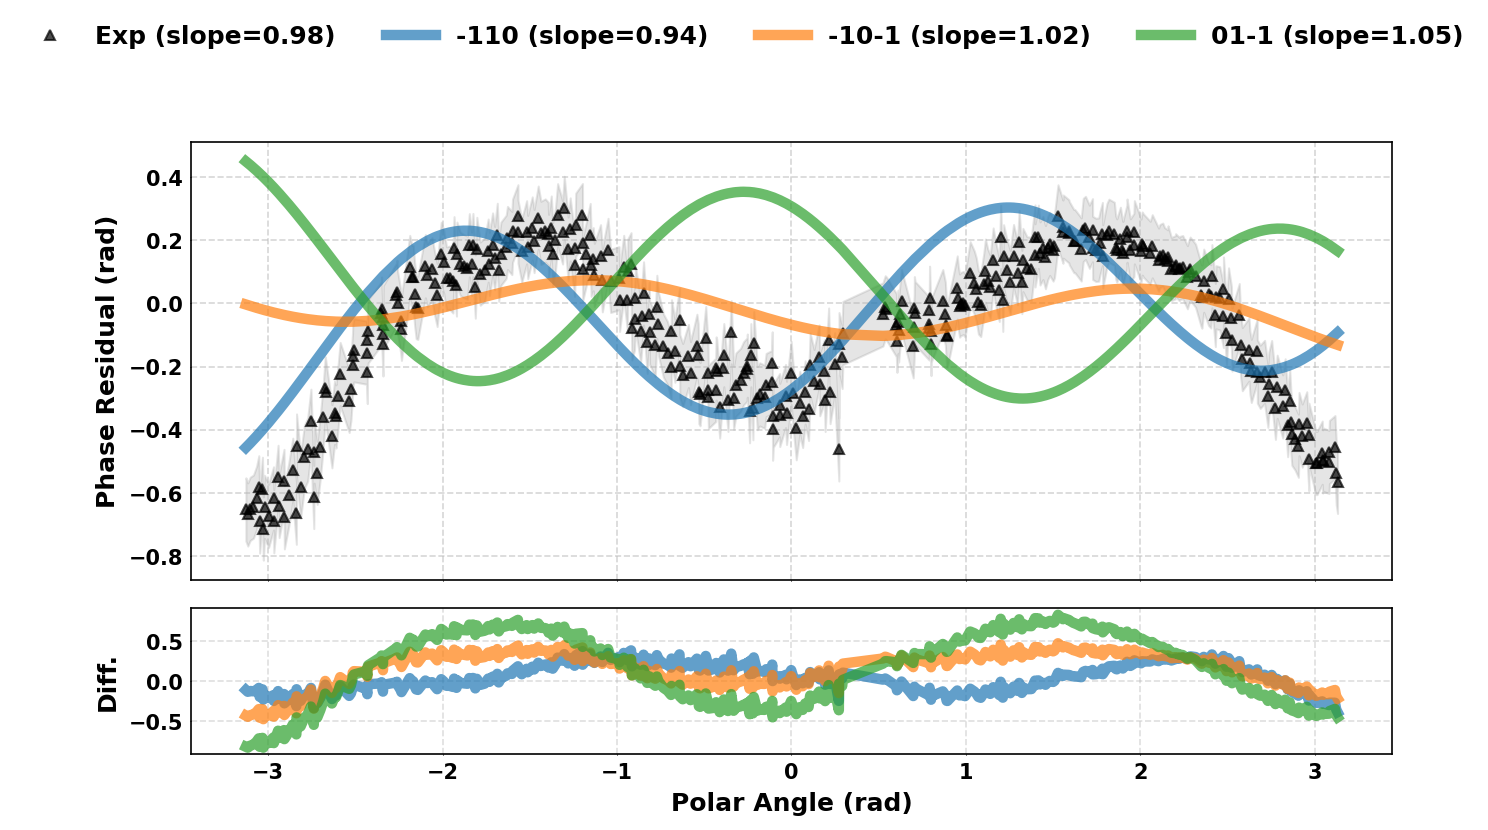

In [27]:
dislo.plot_phase_data_comparison_exp_to_theo(
    angle_final,
    phase_final,
    phase_theo_3_cases,
    b_cases_str,
    save_path=None,
    filter_low_freq=False,
    marker_size=5,
    figsize=(9, 5),
    font_size=12,
    show_slope=True,
    ncol=4,
    fix_exp_slope=0.98,
)

# comparison to simulation ....